In [1]:
import multiprocessing as mp
import sys
#add the path were the models are
sys.path.append("../inProduction/")
import pandas as pd
import numpy as np
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from itertools import repeat
import time
from functools import reduce
from sirPSO import SIR_PSO
#set default theme for plts
theme_set(theme_linedraw())

In [2]:
data = pd.read_csv("../data/estados.csv")
#Select only Sao Paulo
sp = data[data["state"] == "SP"]
#Remove missing values to not crash the intervals
sp = sp.dropna()
sp.head()

,date,state,newCases,mortes,TOTAL,totalCasesPred,sucetivel,Recuperado
41,2020-02-25,SP,1.0,0.0,1.0,1.000000,4.591905e+07,0.000000
42,2020-02-26,SP,0.0,0.0,1.0,1.253639,4.591905e+07,0.140394
43,2020-02-27,SP,0.0,0.0,1.0,1.571138,4.591905e+07,0.316136
44,2020-02-28,SP,0.0,0.0,1.0,1.968710,4.591905e+07,0.536200
45,2020-02-29,SP,1.0,0.0,2.0,2.468231,4.591905e+07,0.812695


In [3]:
#create a series with the cummulative number of cases
y = np.array(sp["TOTAL"])

#Give the number of days since the day of first case confirmed
x = range(0,len(sp["TOTAL"]))

In [4]:
#start model
model = SIR_PSO(tamanhoPop = 50000000, numeroProcessadores = 8)

In [5]:
model.fit(x = x, y = y)
model.predict(x)

2020-04-10 17:54:54,202 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=9.08e+3
2020-04-10 17:55:00,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9083.526926735822, best pos: [0.40247474 0.19949267]


array([1.00000000e+00, 1.44900942e+00, 1.99906527e+00, 2.67310242e+00,
       3.50169446e+00, 4.54715007e+00, 5.82735585e+00, 7.36614662e+00,
       9.30377640e+00, 1.16631677e+01, 1.45203052e+01, 1.81175310e+01,
       2.24729284e+01, 2.77983573e+01, 3.44756341e+01, 4.25125428e+01,
       5.24552136e+01, 6.48356400e+01, 7.96830278e+01, 9.82416004e+01,
       1.21171125e+02, 1.48637343e+02, 1.82705532e+02, 2.24211821e+02,
       2.75722190e+02, 3.38284575e+02, 4.15323444e+02, 5.09633707e+02,
       6.25186234e+02, 7.66903826e+02, 9.40739269e+02, 1.15346822e+03,
       1.41397586e+03, 1.73180388e+03])

In [6]:
from recombinator.optimal_block_length import optimal_block_length as opl
opl(y)

(OptimalBlockLength(b_star_sb=7.082336691795086, b_star_cb=8.107251681655882),)

In [7]:
from recombinator.block_bootstrap import circular_block_bootstrap as cbb

In [8]:
arrays = cbb(x = y, block_length = 8, replications = 1000, replace = True)

In [9]:
sp["lb"] = np.cumsum(np.quantile(np.transpose(arrays), q  = 0.0275, axis = 1))
sp["ub"] = np.cumsum(np.quantile(np.transpose(arrays), q  = 0.975, axis = 1))
sp["meanSeries"] = np.cumsum(np.median(np.transpose(arrays), axis = 1))

sp["date"] = pd.to_datetime(sp["date"])

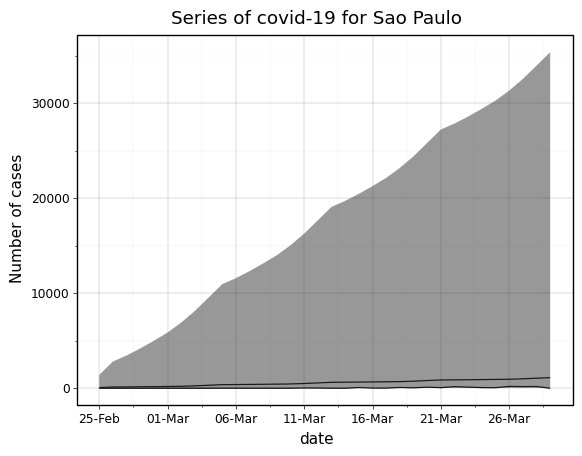

<ggplot: (8770151898295)>

In [10]:
#plot graph using ggplot
(ggplot(sp) + 
    geom_line(aes(x = "date", y = "newCases")) +
    geom_line(aes(x = "date", y = "meanSeries")) +
    geom_ribbon(aes(x = "date", ymin = "lb", ymax = "ub"), alpha = 0.5) +
    scale_x_datetime(breaks = date_breaks('5 days'), labels=date_format('%d-%b')) +
    ggtitle("Series of covid-19 for Sao Paulo") +
    ylab("Number of cases"))

In [11]:
def bootstratpTS(npArray, replicate):
    """
    
    """
    simList = []
    def poissonGen(npArray, replicate = None):
        simSeries = []
        for i in range(0,len(npArray)):
            if i == 0:
                simSeries.append(npArray[i]) 
            else:
                simSeries.append(np.random.poisson(lam = npArray[i] - npArray[i-1], size = 1)[0])
        return np.cumsum(np.array(simSeries))
    for i in range(0,replicate):
        simList.append(poissonGen(npArray))
    return np.array(simList)
simList = bootstratpTS(npArray = y, replicate = 1000)

In [12]:
sp["plb"] = np.quantile(np.transpose(simList), q  = 0.0275, axis = 1)
sp["pub"] = np.quantile(np.transpose(simList), q  = 0.975, axis = 1)
sp["pmeanSeries"] = np.median(np.transpose(simList), axis = 1)

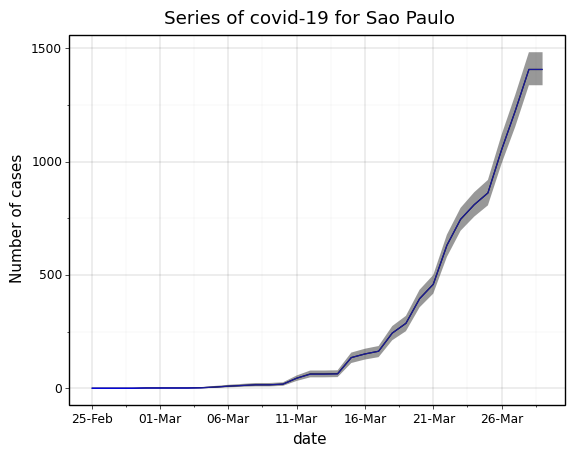

<ggplot: (-9223363266778870931)>

In [13]:
#plot graph using ggplot
(ggplot(sp) + 
    geom_line(aes(x = "date", y = "TOTAL")) +
    geom_line(aes(x = "date", y = "pmeanSeries"), color = "blue") +
    geom_ribbon(aes(x = "date", ymin = "plb", ymax = "pub"), alpha = 0.5) +
    scale_x_datetime(breaks = date_breaks('5 days'), labels=date_format('%d-%b')) +
    ggtitle("Series of covid-19 for Sao Paulo") +
    ylab("Number of cases"))